In [1]:
%load_ext Cython

#pseudocode
'''
define a lattice with random configuration
each lattice site has a plane of rotations that alternates**

'''

'\ndefine a lattice with random configuration\neach lattice site has a plane of rotations that alternates**\n\n'

In [13]:
%%cython -a

from __future__ import division

import numpy as np
import random as random
cimport numpy as np
cimport cython

from numpy cimport abs
from scipy import constants
from libcpp cimport bool
from libc.math cimport exp
from libc.stdlib cimport rand

cdef extern from "limits.h":
    int RAND_MAX

@cython.boundscheck(False)
@cython.wraparound(False)
cdef random_lattice(int N, int M):
    cdef np.float64_t[:] theta =  np.random.uniform(0,2*np.pi, N*M)

    cdef np.ndarray[:,:] L = np.array(np.zeros((N,M), dtype=np.ndarray))
    cdef np.float64_t[:] u1 = np.array([1/np.sqrt(2),1/np.sqrt(2),0])
    cdef np.float64_t[:] u2 = np.array([-1/np.sqrt(2),1/np.sqrt(2),0])
    
    cdef int a = 0
    cdef int b = 0
    cdef int k = 0
    temp = False
    for i in range(N):
        for j in range(M):
            if a % 2 == 0:
                R1 = rotation(theta, k, True)
                L[i,j] = R1.dot(u2)

            else:
                R2 = rotation(theta, k, False)
                L[i,j] = R2.dot(u1)
                
            if (a+1+b) % N == 0 and a != 0 and temp == False:
                temp = True
                b = b + 1
            else:
                a = a + 1
                temp = False
            
            k += 1
  
    return L

@cython.boundscheck(False)
@cython.wraparound(False)
cdef rotation(np.float64_t[:] theta, int k, np.npy_bool c):
    
    cdef np.float64_t[:] C = np.cos(theta)
    cdef np.float64_t[:] S = np.sin(theta)
    cdef np.float64_t[:] t = (1-np.cos(theta))
    cdef np.float64_t[:] u1 = np.array([1/np.sqrt(2),1/np.sqrt(2),0])
    cdef np.float64_t[:] u2 = np.array([-1/np.sqrt(2),1/np.sqrt(2),0])

   
    if c == True:
        R1 = np.array([[C[k]+np.power(u1[0],2)*t[k], u1[0]*u1[1]*t[k]-u1[2]*S[k], u1[0]*u1[2]*t[k]+u1[1]*S[k]],
      [u1[1]*u1[0]*t[k]+u1[2]*S[k], C[k]+np.power(u1[1],2)*t[k], u1[1]*u1[2]*t[k]-u1[0]*S[k]],
      [u1[2]*u1[0]*t[k]-u1[1]*S[k], u1[2]*u1[1]*t[k]+u1[0]*S[k], C[k]+np.power(u1[2],2)*t[k]]])

        return R1

    else:
        R2 = np.array([[C[k]+np.power(u2[0],2)*t[k], u2[0]*u2[1]*t[k]-u2[2]*S[k], u2[0]*u2[2]*t[k]+u2[1]*S[k]],
      [u2[1]*u2[0]*t[k]+u2[2]*S[k], C[k]+np.power(u2[1],2)*t[k], u2[1]*u2[2]*t[k]-u2[0]*S[k]],
      [u2[2]*u2[0]*t[k]-u2[1]*S[k], u2[2]*u2[1]*t[k]+u2[0]*S[k], C[k]+np.power(u2[2],2)*t[k]]])

        return R2
    
    
@cython.boundscheck(False)
@cython.wraparound(False)
cdef unit_vector(vector):
    return vector / np.linalg.norm(vector)


@cython.boundscheck(False)
@cython.wraparound(False)
cdef angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    

@cython.boundscheck(False)
@cython.wraparound(False)
cdef cy_aa_step(np.ndarray[:,:] L, float beta):
    cdef int N = L.shape[0]
    cdef int M = L.shape[1]
    cdef int n, m
    cdef int i = 0
    cdef int k = 0
    temp = False
    for n in range(N):
        for m in range(M):
            cy_aa_update(L, n, m, beta, i)
            if (i+1+k) % N == 0 and i != 0 and temp == False:
                temp = True
                k = k + 1
            else:
                i = i + 1
                temp = False
    return L


@cython.boundscheck(False)
@cython.wraparound(False)
cdef cy_aa_update(np.ndarray[:,:] L, int n, int m, float beta, int i):
    
    cdef int N = L.shape[0]
    cdef int M = L.shape[1]
    
    cdef int[:] r2 = np.array([0,1,0], dtype = np.int32)
    cdef int[:] r1 = np.array([0,-1,0], dtype = np.int32)
    cdef int[:] r3 = np.array([1,0,0], dtype = np.int32)
    cdef int[:] r4 = np.array([-1,0,0], dtype = np.int32)
    
    cdef np.float64_t[:] r1_2 = np.array([1/np.sqrt(2),-1/np.sqrt(2),0])
    cdef np.float64_t[:] r2_2 = np.array([-1/np.sqrt(2),-1/np.sqrt(2),0])
    cdef np.float64_t[:] r3_2 = np.array([1/np.sqrt(2),1/np.sqrt(2),0])
    cdef np.float64_t[:] r4_2 = np.array([-1/np.sqrt(2),1/np.sqrt(2),0])
    
    cdef np.float64_t[:] theta = np.random.uniform(0,2*np.pi,1)
    
    if (i)%2 == 0:
        c = True
    else:
        c = False
        
    R = rotation(theta, 0, c)
    r = R.dot(L[n,m])
    
#initial
    #nearest neighbors
    cdef float H1_i = -1*(3*(L[n,m].dot(r1))*(L[(n + 1)%N,m].dot(r1))-(L[n,m].dot(L[(n + 1)%N, m])))
    cdef float H2_i = -1*(3*(L[n,m].dot(r2))*(L[(n - 1)%N, m].dot(r2))-(L[n,m].dot(L[(n - 1)%N, m])))
    cdef float H3_i = -1*(3*(L[n,m].dot(r3))*(L[n, (m + 1)%M].dot(r3))-(L[n,m].dot(L[n, (m + 1)%M])))
    cdef float H4_i = -1*(3*(L[n,m].dot(r4))*(L[n, (m - 1)%M].dot(r4))-(L[n,m].dot(L[n, (m - 1)%M])))
    #2nd nearest neighbors
    cdef float H1_2i = -1*(1/np.sqrt(2)**3)*(3*(L[n,m].dot(r1_2))*(L[(n + 1)%N, (m + 1)%M].dot(r1_2))-(L[n,m].dot(L[(n + 1)%N,(m + 1)%M])))
    cdef float H2_2i = -1*(1/np.sqrt(2)**3)*(3*(L[n,m].dot(r2_2))*(L[(n + 1)%N, (m - 1)%M].dot(r2_2))-(L[n,m].dot(L[(n + 1)%N, (m - 1)%M])))
    cdef float H3_2i = -1*(1/np.sqrt(2)**3)*(3*(L[n,m].dot(r3_2))*(L[(n - 1)%N, (m + 1)%M].dot(r3_2))-(L[n,m].dot(L[(n - 1)%N, (m + 1)%M])))
    cdef float H4_2i = -1*(1/np.sqrt(2)**3)*(3*(L[n,m].dot(r4_2))*(L[(n - 1)%N, (m - 1)%M].dot(r4_2))-(L[n,m].dot(L[(n - 1)%N, (m - 1)%M])))

#proposed
    #nearest neighbors
    cdef float H1_f = -1*(3*(r.dot(r1))*(L[(n + 1)%N,m].dot(r1))-(r.dot(L[(n + 1)%N, m])))
    cdef float H2_f = -1*(3*(r.dot(r2))*(L[(n - 1)%N, m].dot(r2))-(r.dot(L[(n - 1)%N, m])))
    cdef float H3_f = -1*(3*(r.dot(r3))*(L[n, (m + 1)%M].dot(r3))-(r.dot(L[n, (m + 1)%M])))
    cdef float H4_f = -1*(3*(r.dot(r4))*(L[n, (m - 1)%M].dot(r4))-(r.dot(L[n, (m - 1)%M])))
    #2nd nearest neighbors
    cdef float H1_2f = -1*(1/np.sqrt(2)**3)*(3*(r.dot(r1_2))*(L[(n + 1)%N, (m + 1)%M].dot(r1_2))-(r.dot(L[(n + 1)%N, (m + 1)%M])))
    cdef float H2_2f = -1*(1/np.sqrt(2)**3)*(3*(r.dot(r2_2))*(L[(n + 1)%N, (m - 1)%M].dot(r2_2))-(r.dot(L[(n + 1)%N, (m - 1)%M])))
    cdef float H3_2f = -1*(1/np.sqrt(2)**3)*(3*(r.dot(r3_2))*(L[(n - 1)%N, (m + 1)%M].dot(r3_2))-(r.dot(L[(n - 1)%N, (m + 1)%M])))
    cdef float H4_2f = -1*(1/np.sqrt(2)**3)*(3*(r.dot(r4_2))*(L[(n - 1)%N, (m - 1)%M].dot(r4_2))-(r.dot(L[(n - 1)%N, (m - 1)%M])))
    
    cdef np.float64_t[:] Lp = np.array(L[n,m])
    cdef np.float64_t[:] rp = np.array(r)
    Lp[2] = 0.0
    rp[2] = 0.0
    
    cdef np.float64_t[:] tl = np.array([angle_between(L[n,m], Lp)])
    cdef np.float64_t[:] tr = np.array([angle_between(r, rp)])

    rp = 23

    cdef float H_i = H1_i + H2_i + H3_i + H4_i + H1_2i + H2_2i + H3_2i + H4_2i + rp*np.sin(tl)
    cdef float H_f = H1_f+ H2_f + H3_f + H4_f + H1_2f+ H2_2f + H3_2f + H4_2f + rp*np.sin(tr)
    cdef float H = H_f - H_i
    
    if H <= 0:
        L[n, m] = r 

    elif rand() < RAND_MAX * exp(-beta * H):
        L[n, m] = r 
        
        
@cython.boundscheck(False)
@cython.wraparound(False)
cdef cy_polarization(np.ndarray[:,:] L):

    pol1 = np.array([0.0,0.0,0.0])
    pol2 = np.array([0.0,0.0,0.0])
    pol3 = np.array([0.0,0.0,0.0])
    pol4 = np.array([0.0,0.0,0.0])
    
    for i in range(L.shape[0]):
        for j in range(L.shape[1]):
            if i%2 == 0 and j%2 == 0:
                pol1 = pol1 + L[i,j]
            elif i%2 != 0 and j%2 == 0:
                pol2 = pol2 + L[i,j]
            elif i%2 == 0 and j%2 != 0:
                pol3 = pol3 + L[i,j]
            else:
                pol4 = pol4 + L[i,j]
            
    return pol1, pol2, pol3, pol4

def main():
    ## PARAMETERS
    cdef int N = 32             #size of lattice
    cdef int temp_points = 100  #number of temperature points
    cdef np.float64_t[:] T = np.linspace(.3, 3, temp_points, dtype=np.float64)
    cdef np.float64_t[:] E = np.zeros(temp_points, dtype=np.float64)
    cdef np.float64_t[:] M = np.zeros(temp_points, dtype=np.float64)
    cdef np.float64_t[:] C = np.zeros(temp_points, dtype=np.float64)
    cdef np.float64_t[:] X = np.zeros(temp_points, dtype=np.float64)
    cdef np.float64_t[:] absP1 = np.zeros(temp_points, dtype=np.float64)
    cdef np.float64_t[:] absP2 = np.zeros(temp_points, dtype=np.float64)
    cdef np.float64_t[:] absP3 = np.zeros(temp_points, dtype=np.float64)
    cdef np.float64_t[:] absP4 = np.zeros(temp_points, dtype=np.float64)
    
    cdef int eqsteps = 50000
    cdef int mcsteps = 5000
    cdef float mc = 5000
    cdef float n1 = 1.0/(mc*N*N)
    cdef float n2 = 1.0/(mc*mc*N*N)    

    #step analysis
    cdef np.int32_t[:] MS = np.arange(eqsteps+mcsteps,dtype=np.int32)
    cdef float avg = 1.0/(N*N)
    cdef np.float64_t[:, :] mrange = np.zeros((len(T), eqsteps+mcsteps),dtype=np.float64)

    cdef np.float64_t[:, :] mrange1 = np.zeros((len(T), eqsteps+mcsteps),dtype=np.float64)
    cdef np.float64_t[:, :] mrange2 = np.zeros((len(T), eqsteps+mcsteps),dtype=np.float64)
    cdef np.float64_t[:, :] mrange3 = np.zeros((len(T), eqsteps+mcsteps),dtype=np.float64)
    cdef np.float64_t[:, :] mrange4 = np.zeros((len(T), eqsteps+mcsteps),dtype=np.float64)    

    import time
    import sys
    cdef int a = 0
    cdef int h = 0
    cdef int p = 0
    
    cdef np.ndarray[:,:] L
    cdef float b1 = 1.0 / T[p]
    cdef float b2 = b1 * b1;
    cdef int i = 0
    start_time = time.clock()

    for p in range(len(T)):
        pol1 = np.array([0.0,0.0,0.0])
        pol2 = np.array([0.0,0.0,0.0])
        pol3 = np.array([0.0,0.0,0.0])
        pol4 = np.array([0.0,0.0,0.0])
        
        absp1 = np.array([0.0,0.0,0.0])
        absp2 = np.array([0.0,0.0,0.0])
        absp3 = np.array([0.0,0.0,0.0])
        absp4 = np.array([0.0,0.0,0.0])
        
        p1 = np.array([0.0,0.0,0.0])
        p2 = np.array([0.0,0.0,0.0])
        p3 = np.array([0.0,0.0,0.0])
        p4 = np.array([0.0,0.0,0.0])
        
#         e1 = absm1 = e2 = m2 = 0.0
#         m = 0.0

        L = random_lattice(N, N)
        b1 = 1.0 / T[p] 
        b2 = b1 * b1;
        for i in range(eqsteps):
            cy_aa_step(L, b1)
            pol1, pol2, pol3, pol4 = cy_polarization(L)

            p1 = pol1 + p1
            p2 = pol2 + p2
            p3 = pol3 + p3
            p4 = pol4 + p4

            mrange1[h][i]=np.linalg.norm(p1)*avg*(1/(i+1))
            mrange2[h][i]=np.linalg.norm(p2)*avg*(1/(i+1))
            mrange3[h][i]=np.linalg.norm(p3)*avg*(1/(i+1))
            mrange4[h][i]=np.linalg.norm(p4)*avg*(1/(i+1))

        for i in range(mcsteps):
            cy_aa_step(L, b1)
            pol1, pol2, pol3, pol4 = cy_polarization(L)
            
            absp1 = pol1 + absp1
            absp2 = pol2 + absp2
            absp3 = pol3 + absp3
            absp4 = pol4 + absp4
            
            p1 = pol1 + p1
            p2 = pol2 + p2
            p3 = pol3 + p3
            p4 = pol4 + p4
            
            mrange1[h][i+eqsteps]=np.linalg.norm(p1)*avg*(1/(i+eqsteps))
            mrange2[h][i+eqsteps]=np.linalg.norm(p2)*avg*(1/(i+eqsteps))
            mrange3[h][i+eqsteps]=np.linalg.norm(p3)*avg*(1/(i+eqsteps))
            mrange4[h][i+eqsteps]=np.linalg.norm(p4)*avg*(1/(i+eqsteps))

                
        h += 1

        a += 1
        print a 
        
        absP1[p] = n1*np.linalg.norm(absp1)
        absP2[p] = n1*np.linalg.norm(absp2)
        absP3[p] = n1*np.linalg.norm(absp3)
        absP4[p] = n1*np.linalg.norm(absp4)
        
    
    cdef float seconds = time.clock() - start_time
    cdef float minutes = 0
    cdef float hours = 0
    cdef str x = ''
    
    if seconds >= 60:
        minutes = seconds / 60.0
        seconds = seconds - minutes * 60
    if minutes >= 60:
        hours = minutes / 60.0
        minutes = minutes - hours * 60

    if hours > 0:
        x = 'Calculation took ' + str('%.0f' % hours) + ' hours, ' + str('%.0f' % minutes) + ' minutes and ' + str( '%.0f' % seconds) + " seconds."
    elif hours == 0 and minutes > 0:
        x = 'Calculation took ' + str('%.0f' % minutes) + ' minutes and ' + str( '%.0f' % seconds) + " seconds."
    else:
        x = 'Calculation took ' + str('%.0f' % seconds) + " seconds."
        
    return x, np.asarray(T), np.asarray(absP1), np.asarray(absP2), np.asarray(absP3), np.asarray(absP4), N, np.asarray(MS), np.asarray(mrange1), np.asarray(mrange2), np.asarray(mrange3), np.asarray(mrange4), eqsteps, mcsteps
    

def display(x, T, absP1, absP2, absP3, absP4, N, MS, mrange1, mrange2, mrange3, mrange4, eqsteps, mcsteps):
    import matplotlib.pyplot as plt

    f = plt.figure(figsize=(36, 20)); # plot the calculated values    

    plt.title('-'+np.str(N)+'x'+np.str(N)+' lattice-' + ' ' + x,fontsize=50)
    plt.axis('off')

    sp =  f.add_subplot(2, 2, 1 );
    plt.scatter(T, absP1, s=70, marker='o', color='IndianRed')
    plt.xticks(fontsize = 30);
    plt.yticks(fontsize = 30);
    plt.xlabel("Temperature (T)", fontsize=40);
    plt.ylabel("Pol1 ", fontsize=40);     plt.axis('tight');

    sp =  f.add_subplot(2, 2, 2 );
    plt.scatter(T, absP2, s=70, marker='o', color='RoyalBlue')
    #plt.vlines(2.27,0,1, lw = 2)
    plt.xticks(fontsize = 30);
    plt.yticks(fontsize = 30);
    plt.xlabel("Temperature (T)", fontsize=40); 
    plt.ylabel("Pol2 ", fontsize=40);   plt.axis('tight');
    
    sp =  f.add_subplot(2, 2, 3 );
    plt.scatter(T, absP3, s=70, marker='o', color='IndianRed')
    plt.xticks(fontsize = 30);
    plt.yticks(fontsize = 30);
    plt.xlabel("Temperature (T)", fontsize=40);  
    plt.ylabel("Pol3 ", fontsize=40);   plt.axis('tight');   

    sp =  f.add_subplot(2, 2, 4 );
    plt.scatter(T, absP4, s=70, marker='o', color='RoyalBlue')
    plt.xticks(fontsize = 30);
    plt.yticks(fontsize = 30);
    plt.xlabel("Temperature (T)", fontsize=40); 
    plt.ylabel("Pol4", fontsize=40);   plt.axis('tight');

    import math
    import colorsys
    r = len(T)
    HSV_tuples = [(q*2.8/r, 1, .8) for q in range(r)]
    RGB_tuples = map(lambda q: colorsys.hsv_to_rgb(*q), HSV_tuples)
  
    g = plt.figure(figsize=(36, 20));
    
    ct = 2/math.atanh(math.sqrt(1/2))
    for q in range(0, len(RGB_tuples), 3): 
         
        sr =  g.add_subplot(2, 2, 1 );
        plt.plot(MS, mrange1[q], color=(RGB_tuples[q][0], RGB_tuples[q][1], RGB_tuples[q][2]),lw = 2);
        plt.xticks(fontsize = 30);
        plt.yticks(fontsize = 30);
        plt.xlabel("MC steps per lattice site", fontsize=30); 
        plt.ylabel("Polarization 1 ", fontsize=30);
        
        sr =  g.add_subplot(2, 2, 2 );
        plt.plot(MS, mrange2[q], color=(RGB_tuples[q][0], RGB_tuples[q][1], RGB_tuples[q][2]),lw = 2);
        plt.xticks(fontsize = 30);
        plt.yticks(fontsize = 30);
        plt.xlabel("MC steps per lattice site", fontsize=30); 
        plt.ylabel("Polarization 2 ", fontsize=30);
        
        sr =  g.add_subplot(2, 2, 3 );
        plt.plot(MS, mrange3[q], color=(RGB_tuples[q][0], RGB_tuples[q][1], RGB_tuples[q][2]),lw = 2);
        plt.xticks(fontsize = 30);
        plt.yticks(fontsize = 30);
        plt.xlabel("MC steps per lattice site", fontsize=30); 
        plt.ylabel("Polarization 3 ", fontsize=30);
        
        sr =  g.add_subplot(2, 2, 4 );
        plt.plot(MS, mrange4[q], color=(RGB_tuples[q][0], RGB_tuples[q][1], RGB_tuples[q][2]),lw = 2);
        plt.xticks(fontsize = 30);
        plt.yticks(fontsize = 30);
        plt.xlabel("MC steps per lattice site", fontsize=30); 
        plt.ylabel("Polarization 4 ", fontsize=30);


    plt.legend(bbox_to_anchor=(1,1), loc=1,fontsize = 30);
    #plt.axis([-10,eqsteps+mcsteps,np.min(mrange1),1]);

C:\Users\Andrew\Anaconda2\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Andrew\.ipython\cython\_cython_magic_302f250d84cab92847a250b1ca9a8e6a.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [14]:
values = main()

1
2
3
4
5
6
7
8
9
10


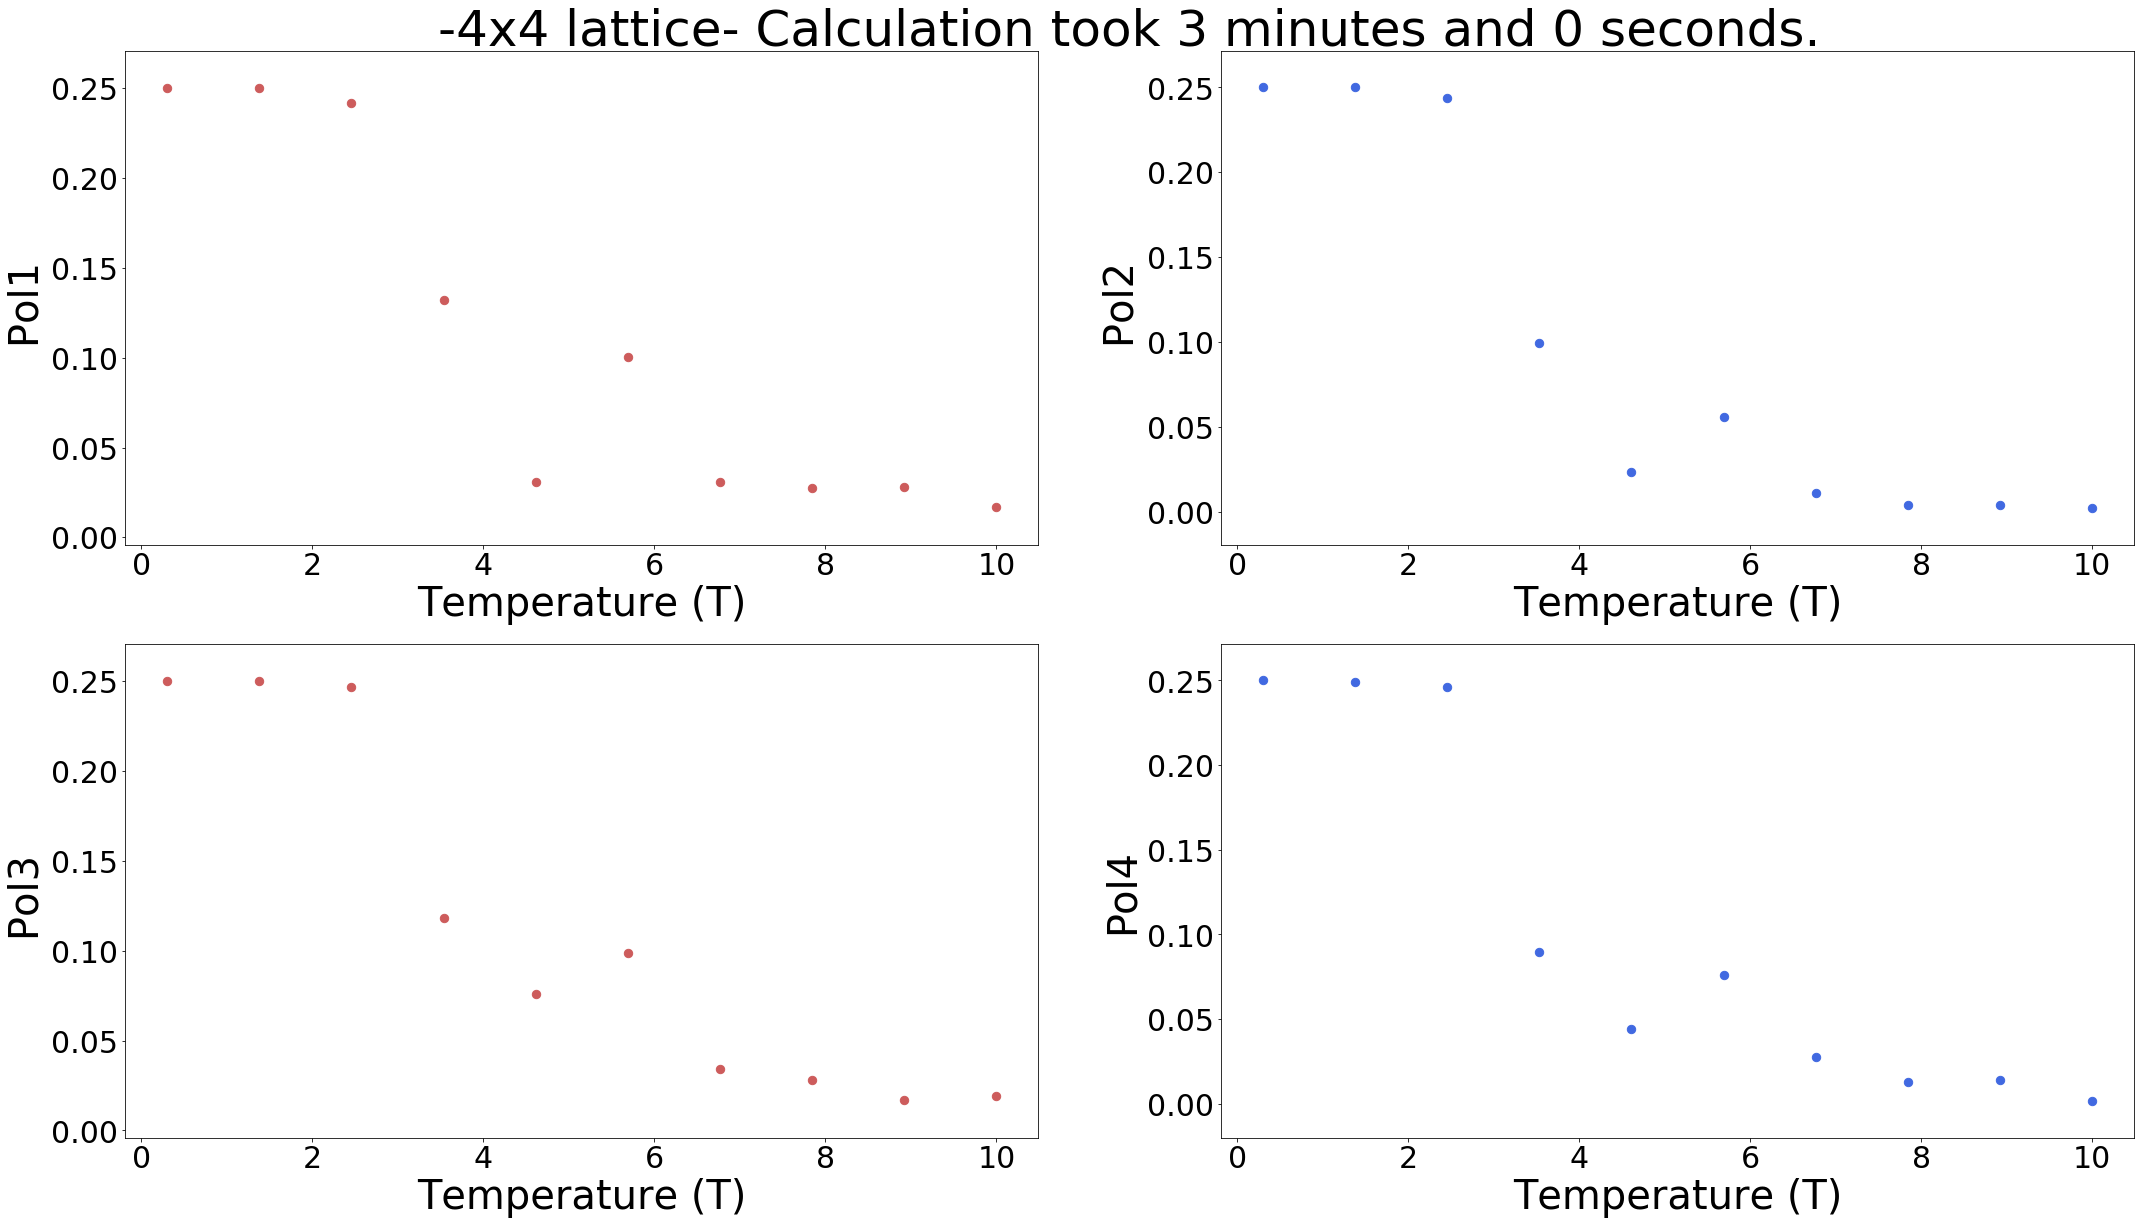

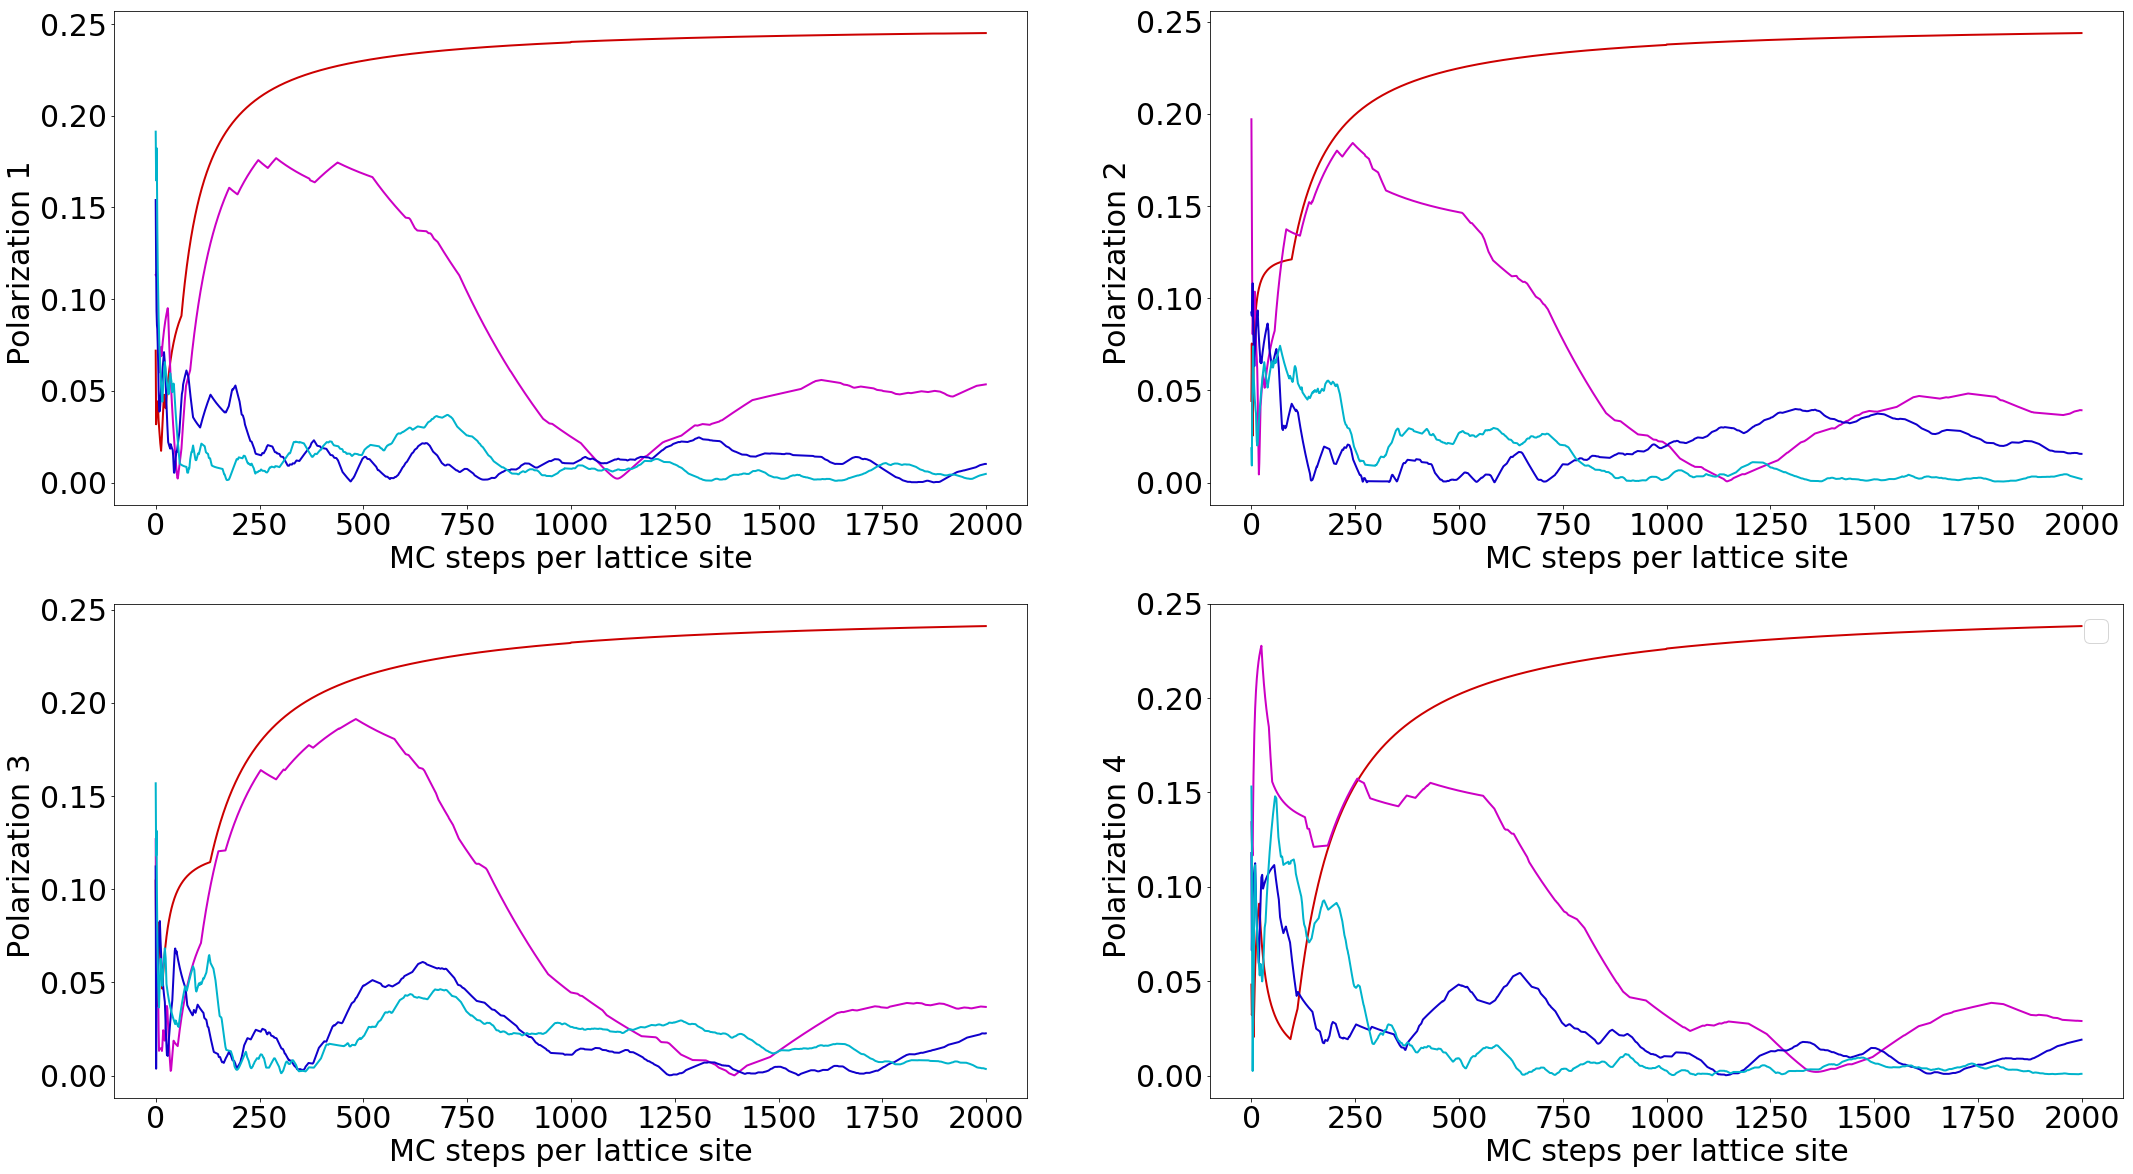

In [12]:
x=values[0]
T=values[1]
M1 = values[2]
M2=values[3]
M3 = values[4]
M4 = values[5]
N=values[6]
MS=values[7]
mrange1=values[8]
mrange2=values[9]
mrange3=values[10]
mrange4=values[11]
eqsteps=values[12]
mcsteps=values[13]

display(x, T, M1, M2, M3, M4, N, MS, mrange1, mrange2, mrange3, mrange4, eqsteps, mcsteps)